# **Neural Network Exercise 3**
## Part 1

---

Teacher : Dr.Kheradpisheh 

Student : Amin Dehghan Monfared	     
SID : 99422085 



Spring 2021 

In [ ]:
import os
import sys
import random
import time
import datetime
import shutil

import cv2


import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt




from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from scipy import stats


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter

import functools
import operator




# Get Data

https://www.kaggle.com/thedownhill/art-images-drawings-painting-sculpture-engraving

In [ ]:
# Download Data From Kaggle api

!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d thedownhill/art-images-drawings-painting-sculpture-engraving


# unzip files 
import zipfile 

zip_ref = zipfile.ZipFile('art-images-drawings-painting-sculpture-engraving.zip','r')
zip_ref.extractall('./data/')
zip_ref.close()

!rm ./art-images-drawings-painting-sculpture-engraving.zip

Saving kaggle.json to kaggle.json
 98% 573M/583M [00:06<00:00, 85.7MB/s]
100% 583M/583M [00:06<00:00, 94.6MB/s]


# Load Data

(224, 224, 3)

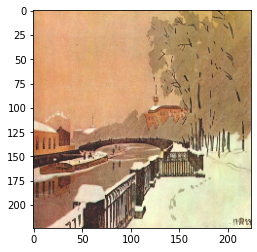

In [ ]:
IMG_PATH ='/content/data/dataset/dataset_updated/training_set/drawings/'


img = cv2.imread(IMG_PATH+"167176.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)
img.shape

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, 1)

train_ids = next(os.walk(IMG_PATH))[2]

In [ ]:
%%time
X_train = np.zeros((len(train_ids)-86, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
missing_count = 0
print('Getting train images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = IMG_PATH + id_+''
    try:
        img = imread(path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n-missing_count] = img
    except:
#         print(" Problem with: "+path)
        missing_count += 1

X_train = X_train.astype('float32') / 255.
y_train = X_train.mean(axis=3,keepdims=True)
print("Total missing: "+ str(missing_count))

Getting train images ... 


100%|██████████| 1107/1107 [00:16<00:00, 66.17it/s]


Total missing: 86
CPU times: user 18.8 s, sys: 15 s, total: 33.8 s
Wall time: 18.4 s


In [ ]:
X_train.shape , y_train.shape

((1021, 256, 256, 3), (1021, 256, 256, 1))

In [ ]:
X_train , y_train = y_train, X_train

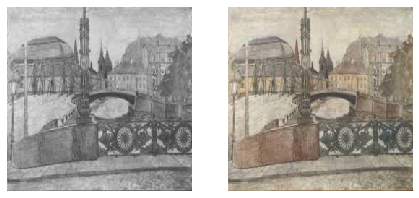

In [ ]:
plt.subplot(1,2,1)
imshow(X_train[5].reshape(256,256))
plt.axis('off')

plt.subplot(1,2,2)
imshow(y_train[5])
plt.axis('off')
plt.show()

In [ ]:
class data_map(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [ ]:
# prepare data for training 

batch_size = 64

X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor  = torch.tensor(y_train, dtype=torch.float)

train_map = data_map(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_map,shuffle=True)


# RGB Method

In [ ]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    #img = imread(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()

      img_gray = rgb2gray(img_original)
      img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()

    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_gray, target

In [ ]:
TRAIN_PATH = '/content/data/dataset/dataset_updated/training_set/'
VAL_PATH = '/content/data/dataset/dataset_updated/validation_set/'

In [ ]:
choosed_class = 'drawings'
for root, dirs, files in os.walk('/content/data/dataset/dataset_updated', topdown=True):

  # To simplifiy problem we just usig drawings folder and clear 
  if choosed_class  not in root and dirs == []:
    print('{} Deleted!'.format(root))
    shutil.rmtree(root)

  # Remove Broken files
  elif  dirs == [] :
    
    train_ids = next(os.walk(root))[2]
    print('Checking train images in {} ... '.format(root))
    sys.stdout.flush()

    missing_count = 0
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        path = root +'/'+ id_+''
        try:
            img = imread(path)
        except:
            #print(" Problem with: "+path)
            missing_count += 1
            os.remove(path)
          
    print("\nTotal missing: "+ str(missing_count))
    sys.stdout.flush()

Checking train images in /content/data/dataset/dataset_updated/training_set/drawings ... 


100%|██████████| 1107/1107 [00:02<00:00, 408.17it/s]


Total missing: 0
/content/data/dataset/dataset_updated/validation_set/iconography Deleted!
/content/data/dataset/dataset_updated/validation_set/sculpture Deleted!
/content/data/dataset/dataset_updated/validation_set/engraving Deleted!
Checking train images in /content/data/dataset/dataset_updated/validation_set/drawings ... 



100%|██████████| 122/122 [00:00<00:00, 410.19it/s]


Total missing: 0


/content/data/dataset/dataset_updated/validation_set/painting Deleted!


In [ ]:
# Training
train_transforms = transforms.Compose([transforms.Resize((256,256)), transforms.Normalize((0.5,)*3, (0.5,)*3)])
train_imagefolder = GrayscaleImageFolder(TRAIN_PATH, train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=16, shuffle=True)

# Validation 
val_transforms = transforms.Compose([transforms.Resize((256,256)), transforms.Normalize((0.5,)*3, (0.5,)*3), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder(VAL_PATH , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=16, shuffle=False)

In [ ]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += nmultimodal
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input,ab_output, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 

  colored_image = torch.cat((grayscale_input, ab_output), 0).numpy() # combine channels
  colored_image = colored_image.transpose((1, 2, 0))  # rescale for matplotlib
  colored_image[:, :, 0:1] = colored_image[:, :, 0:1] * 100
  colored_image[:, :, 1:3] = colored_image[:, :, 1:3] * 255 - 128   
  colored_image = lab2rgb(colored_image.astype(np.float64))

  orig_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  orig_image = orig_image.transpose((1, 2, 0))  # rescale for matplotlib
  orig_image[:, :, 0:1] = orig_image[:, :, 0:1] * 100
  orig_image[:, :, 1:3] = orig_image[:, :, 1:3] * 255 - 128   
  orig_image = lab2rgb(orig_image.astype(np.float64))

  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=colored_image, fname='{}{}'.format(save_path['colorized'], save_name))
    plt.imsave(arr=orig_image, fnammultimodale='{}{}'.format(save_path['original'], save_name))

## Creat Model

In [ ]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kemultimodalrnel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

## Train

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 20 == 0 or i+1 == len(train_loader):
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i+1, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 


  return losses.avg

In [ ]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_ab.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 5)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/colorized/', 'original':'outputs/original/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(),ab_input=input_ab[j].detach().cpu(), 
               ab_output=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0 or i+1 == len(val_loader):
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i+1, len(val_loader), batch_time=batch_time, loss=losses))

  return losses.avg

In [ ]:
use_gpu = torch.cuda.is_available()
use_gpu

True

In [ ]:
model = ColorizationNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0)
criterion = nn.MSELoss()

In [ ]:
# Move model and loss function to GPU
if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()

In [ ]:
# Make folders and set parameters
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 50

In [ ]:
# Train model
for epoch in range(epochs):
  # Train for one epoch, then validate
  train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    losses = validate(val_loader, model, criterion, save_images, epoch)
  # Save checkpoint and replace old best model if current model is better
  if losses < best_losses:
    best_losses = losses
    torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))

Starting training epoch 0
Epoch: [0][1/70]	Time 0.461 (0.461)	Data 0.423 (0.423)	Loss 0.7503 (0.7503)	
Epoch: [0][21/70]	Time 0.423 (0.432)	Data 0.394 (0.402)	Loss 0.2110 (0.4036)	
Epoch: [0][41/70]	Time 0.421 (0.429)	Data 0.392 (0.399)	Loss 0.0479 (0.2558)	
Epoch: [0][61/70]	Time 0.418 (0.429)	Data 0.388 (0.399)	Loss 0.0115 (0.1805)	
Epoch: [0][70/70]	Time 0.089 (0.424)	Data 0.076 (0.394)	Loss 0.0154 (0.1605)	
Finished training epoch 0


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 21 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [1/8]	Time 0.638 (0.638)	Loss 0.0164 (0.0164)	
Validate: [8/8]	Time 0.216 (0.365)	Loss 0.0117 (0.0149)	
Finished validation.
Starting training epoch 1
Epoch: [1][1/70]	Time 0.452 (0.452)	Data 0.420 (0.420)	Loss 0.0073 (0.0073)	
Epoch: [1][21/70]	Time 0.424 (0.433)	Data 0.394 (0.404)	Loss 0.0045 (0.0059)	
Epoch: [1][41/70]	Time 0.417 (0.430)	Data 0.388 (0.400)	Loss 0.0030 (0.0052)	
Epoch: [1][61/70]	Time 0.448 (0.429)	Data 0.418 (0.399)	Loss 0.0027 (0.0046)	
Epoch: [1][70/70]	Time 0.088 (0.423)	Data 0.074 (0.393)	Loss 0.0122 (0.0045)	
Finished training epoch 1


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [1/8]	Time 0.630 (0.630)	Loss 0.0043 (0.0043)	
Validate: [8/8]	Time 0.204 (0.359)	Loss 0.0014 (0.0062)	
Finished validation.
Starting training epoch 2
Epoch: [2][1/70]	Time 0.434 (0.434)	Data 0.402 (0.402)	Loss 0.0034 (0.0034)	
Epoch: [2][21/70]	Time 0.431 (0.429)	Data 0.401 (0.399)	Loss 0.0030 (0.0032)	
Epoch: [2][41/70]	Time 0.424 (0.427)	Data 0.395 (0.397)	Loss 0.0019 (0.0030)	
Epoch: [2][61/70]	Time 0.445 (0.427)	Data 0.415 (0.397)	Loss 0.0026 (0.0028)	
Epoch: [2][70/70]	Time 0.091 (0.422)	Data 0.077 (0.392)	Loss 0.0035 (0.0027)	
Finished training epoch 2
Validate: [1/8]	Time 0.627 (0.627)	Loss 0.0033 (0.0033)	
Validate: [8/8]	Time 0.201 (0.357)	Loss 0.0010 (0.0028)	
Finished validation.
Starting training epoch 3
Epoch: [3][1/70]	Time 0.445 (0.445)	Data 0.413 (0.413)	Loss 0.0022 (0.0022)	
Epoch: [3][21/70]	Time 0.414 (0.429)	Data 0.385 (0.399)	Loss 0.0015 (0.0022)	
Epoch: [3][41/70]	Time 0.415 (0.429)	Data 0.384 (0.399)	Loss 0.0023 (0.0022)	
Epoch: [3][61/70]	Time 0.419 (

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 12 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [1/8]	Time 0.636 (0.636)	Loss 0.0029 (0.0029)	
Validate: [8/8]	Time 0.209 (0.361)	Loss 0.0009 (0.0023)	
Finished validation.
Starting training epoch 4
Epoch: [4][1/70]	Time 0.423 (0.423)	Data 0.391 (0.391)	Loss 0.0020 (0.0020)	
Epoch: [4][21/70]	Time 0.477 (0.434)	Data 0.447 (0.404)	Loss 0.0016 (0.0023)	
Epoch: [4][41/70]	Time 0.421 (0.430)	Data 0.390 (0.400)	Loss 0.0019 (0.0021)	
Epoch: [4][61/70]	Time 0.416 (0.429)	Data 0.387 (0.399)	Loss 0.0024 (0.0021)	
Epoch: [4][70/70]	Time 0.087 (0.423)	Data 0.074 (0.393)	Loss 0.0028 (0.0021)	
Finished training epoch 4


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [1/8]	Time 0.636 (0.636)	Loss 0.0028 (0.0028)	
Validate: [8/8]	Time 0.203 (0.357)	Loss 0.0007 (0.0020)	
Finished validation.
Starting training epoch 5
Epoch: [5][1/70]	Time 0.445 (0.445)	Data 0.413 (0.413)	Loss 0.0023 (0.0023)	
Epoch: [5][21/70]	Time 0.424 (0.429)	Data 0.395 (0.399)	Loss 0.0022 (0.0017)	
Epoch: [5][41/70]	Time 0.417 (0.426)	Data 0.388 (0.396)	Loss 0.0017 (0.0019)	
Epoch: [5][61/70]	Time 0.430 (0.427)	Data 0.400 (0.397)	Loss 0.0011 (0.0018)	
Epoch: [5][70/70]	Time 0.086 (0.422)	Data 0.074 (0.392)	Loss 0.0018 (0.0018)	
Finished training epoch 5


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [1/8]	Time 0.635 (0.635)	Loss 0.0026 (0.0026)	
Validate: [8/8]	Time 0.203 (0.359)	Loss 0.0008 (0.0018)	
Finished validation.
Starting training epoch 6
Epoch: [6][1/70]	Time 0.441 (0.441)	Data 0.409 (0.409)	Loss 0.0026 (0.0026)	
Epoch: [6][21/70]	Time 0.428 (0.434)	Data 0.399 (0.404)	Loss 0.0016 (0.0017)	
Epoch: [6][41/70]	Time 0.419 (0.433)	Data 0.388 (0.403)	Loss 0.0017 (0.0018)	
Epoch: [6][61/70]	Time 0.434 (0.431)	Data 0.405 (0.401)	Loss 0.0015 (0.0018)	
Epoch: [6][70/70]	Time 0.087 (0.426)	Data 0.075 (0.396)	Loss 0.0012 (0.0018)	
Finished training epoch 6


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [1/8]	Time 0.632 (0.632)	Loss 0.0025 (0.0025)	
Validate: [8/8]	Time 0.202 (0.360)	Loss 0.0008 (0.0018)	
Finished validation.
Starting training epoch 7
Epoch: [7][1/70]	Time 0.446 (0.446)	Data 0.414 (0.414)	Loss 0.0020 (0.0020)	
Epoch: [7][21/70]	Time 0.419 (0.431)	Data 0.390 (0.401)	Loss 0.0012 (0.0016)	
Epoch: [7][41/70]	Time 0.420 (0.428)	Data 0.391 (0.398)	Loss 0.0015 (0.0016)	
Epoch: [7][61/70]	Time 0.424 (0.427)	Data 0.394 (0.397)	Loss 0.0011 (0.0017)	
Epoch: [7][70/70]	Time 0.095 (0.422)	Data 0.082 (0.392)	Loss 0.0030 (0.0016)	
Finished training epoch 7
Validate: [1/8]	Time 0.636 (0.636)	Loss 0.0024 (0.0024)	
Validate: [8/8]	Time 0.205 (0.361)	Loss 0.0008 (0.0018)	
Finished validation.
Starting training epoch 8
Epoch: [8][1/70]	Time 0.427 (0.427)	Data 0.395 (0.395)	Loss 0.0020 (0.0020)	
Epoch: [8][21/70]	Time 0.425 (0.426)	Data 0.395 (0.396)	Loss 0.0016 (0.0017)	
Epoch: [8][41/70]	Time 0.419 (0.427)	Data 0.390 (0.397)	Loss 0.0022 (0.0017)	
Epoch: [8][61/70]	Time 0.439 (

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

## Results

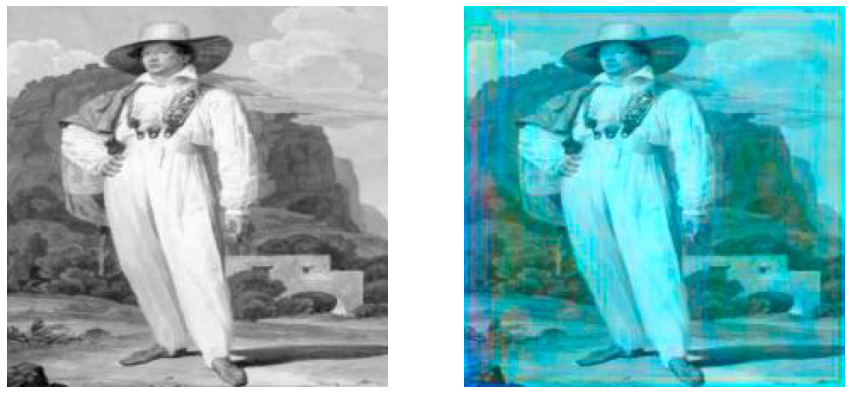

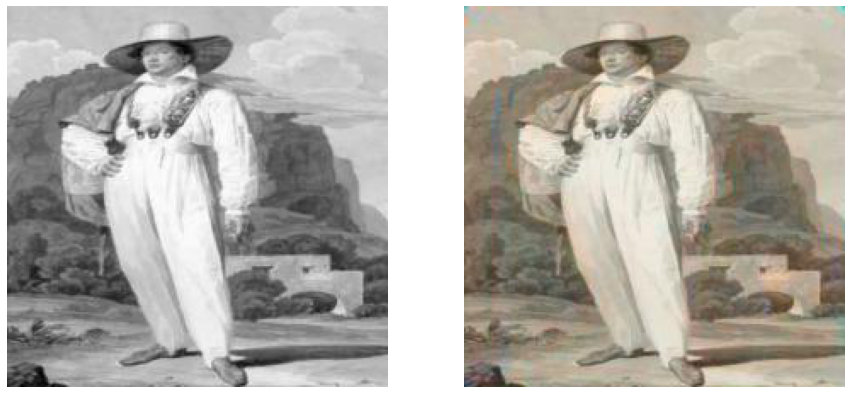

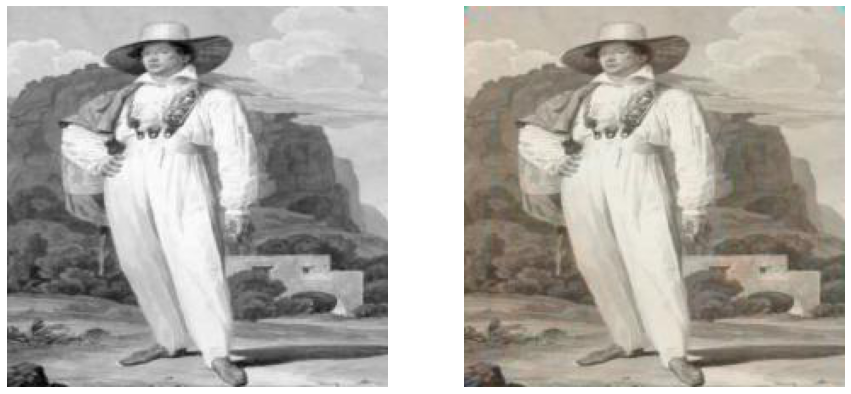

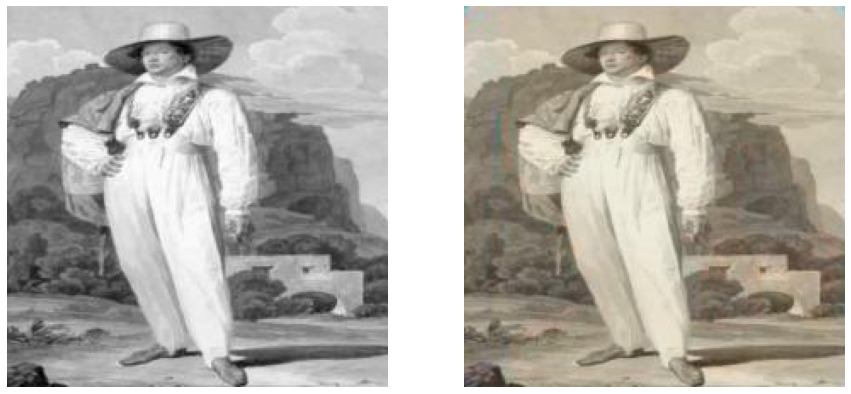

In [ ]:
# Show images 
import matplotlib.image as mpimg
image_pairs = [('outputs/color/img-0-epoch-0.jpg', 'outputs/gray/img-0-epoch-0.jpg'),
               ('outputs/color/img-0-epoch-10.jpg', 'outputs/gray/img-0-epoch-10.jpg'),
                ('outputs/color/img-0-epoch-20.jpg', 'outputs/gray/img-0-epoch-20.jpg'),
                ('outputs/color/img-0-epoch-28.jpg', 'outputs/gray/img-0-epoch-28.jpg')]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()

# LAB Method

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time

In [ ]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    #img = imread(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target

In [ ]:
TRAIN_PATH = '/content/data/dataset/dataset_updated/training_set/'
VAL_PATH = '/content/data/dataset/dataset_updated/validation_set/'

In [ ]:
choosed_class = 'drawings'
for root, dirs, files in os.walk('/content/data/dataset/dataset_updated', topdown=True):

  # To simplifiy problem we just usig drawings folder and clear 
  if choosed_class  not in root and dirs == []:
    print('{} Deleted!'.format(root))
    shutil.rmtree(root)

  # Remove Broken files
  elif  dirs == [] :
    
    train_ids = next(os.walk(root))[2]
    print('Checking train images in {} ... '.format(root))
    sys.stdout.flush()

    missing_count = 0
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        path = root +'/'+ id_+''
        try:
            img = imread(path)
        except:
            #print(" Problem with: "+path)
            missing_count += 1
            os.remove(path)
          
    print("\nTotal missing: "+ str(missing_count))
    sys.stdout.flush()

Checking train images in /content/data/dataset/dataset_updated/training_set/drawings ... 


100%|██████████| 1107/1107 [00:02<00:00, 408.17it/s]


Total missing: 0
/content/data/dataset/dataset_updated/validation_set/iconography Deleted!
/content/data/dataset/dataset_updated/validation_set/sculpture Deleted!
/content/data/dataset/dataset_updated/validation_set/engraving Deleted!
Checking train images in /content/data/dataset/dataset_updated/validation_set/drawings ... 



100%|██████████| 122/122 [00:00<00:00, 410.19it/s]


Total missing: 0


/content/data/dataset/dataset_updated/validation_set/painting Deleted!


In [ ]:
# Training
train_transforms = transforms.Compose([transforms.Resize((256,256)), transforms.Normalize((0.5,)*3, (0.5,)*3)])
train_imagefolder = GrayscaleImageFolder(TRAIN_PATH, train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=16, shuffle=True)

# Validation 
val_transforms = transforms.Compose([transforms.Resize((256,256)), transforms.Normalize((0.5,)*3, (0.5,)*3), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder(VAL_PATH , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=16, shuffle=False)

In [ ]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input,ab_output, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 

  colored_image = torch.cat((grayscale_input, ab_output), 0).numpy() # combine channels
  colored_image = colored_image.transpose((1, 2, 0))  # rescale for matplotlib
  colored_image[:, :, 0:1] = colored_image[:, :, 0:1] * 100
  colored_image[:, :, 1:3] = colored_image[:, :, 1:3] * 255 - 128   
  colored_image = lab2rgb(colored_image.astype(np.float64))

  orig_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  orig_image = orig_image.transpose((1, 2, 0))  # rescale for matplotlib
  orig_image[:, :, 0:1] = orig_image[:, :, 0:1] * 100
  orig_image[:, :, 1:3] = orig_image[:, :, 1:3] * 255 - 128   
  orig_image = lab2rgb(orig_image.astype(np.float64))

  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=colored_image, fname='{}{}'.format(save_path['colorized'], save_name))
    plt.imsave(arr=orig_image, fname='{}{}'.format(save_path['original'], save_name))

## Creat Model

In [ ]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

## Train

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 20 == 0 or i+1 == len(train_loader):
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i+1, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 


  return losses.avg

In [ ]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_ab.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 5)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/colorized/', 'original':'outputs/original/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(),ab_input=input_ab[j].detach().cpu(), 
               ab_output=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0 or i+1 == len(val_loader):
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i+1, len(val_loader), batch_time=batch_time, loss=losses))

  return losses.avg

In [ ]:
use_gpu = torch.cuda.is_available()
use_gpu

True

In [ ]:
model = ColorizationNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0)
criterion = nn.MSELoss()

In [ ]:
# Move model and loss function to GPU
if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()

In [ ]:
# Make folders and set parameters
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 50

In [ ]:
# Train model
for epoch in range(epochs):
  # Train for one epoch, then validate
  train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    losses = validate(val_loader, model, criterion, save_images, epoch)
  # Save checkpoint and replace old best model if current model is better
  if losses < best_losses:
    best_losses = losses
    torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))

Starting training epoch 0
Epoch: [0][1/70]	Time 0.461 (0.461)	Data 0.423 (0.423)	Loss 0.7503 (0.7503)	
Epoch: [0][21/70]	Time 0.423 (0.432)	Data 0.394 (0.402)	Loss 0.2110 (0.4036)	
Epoch: [0][41/70]	Time 0.421 (0.429)	Data 0.392 (0.399)	Loss 0.0479 (0.2558)	
Epoch: [0][61/70]	Time 0.418 (0.429)	Data 0.388 (0.399)	Loss 0.0115 (0.1805)	
Epoch: [0][70/70]	Time 0.089 (0.424)	Data 0.076 (0.394)	Loss 0.0154 (0.1605)	
Finished training epoch 0


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 21 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [1/8]	Time 0.638 (0.638)	Loss 0.0164 (0.0164)	
Validate: [8/8]	Time 0.216 (0.365)	Loss 0.0117 (0.0149)	
Finished validation.
Starting training epoch 1
Epoch: [1][1/70]	Time 0.452 (0.452)	Data 0.420 (0.420)	Loss 0.0073 (0.0073)	
Epoch: [1][21/70]	Time 0.424 (0.433)	Data 0.394 (0.404)	Loss 0.0045 (0.0059)	
Epoch: [1][41/70]	Time 0.417 (0.430)	Data 0.388 (0.400)	Loss 0.0030 (0.0052)	
Epoch: [1][61/70]	Time 0.448 (0.429)	Data 0.418 (0.399)	Loss 0.0027 (0.0046)	
Epoch: [1][70/70]	Time 0.088 (0.423)	Data 0.074 (0.393)	Loss 0.0122 (0.0045)	
Finished training epoch 1


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [1/8]	Time 0.630 (0.630)	Loss 0.0043 (0.0043)	
Validate: [8/8]	Time 0.204 (0.359)	Loss 0.0014 (0.0062)	
Finished validation.
Starting training epoch 2
Epoch: [2][1/70]	Time 0.434 (0.434)	Data 0.402 (0.402)	Loss 0.0034 (0.0034)	
Epoch: [2][21/70]	Time 0.431 (0.429)	Data 0.401 (0.399)	Loss 0.0030 (0.0032)	
Epoch: [2][41/70]	Time 0.424 (0.427)	Data 0.395 (0.397)	Loss 0.0019 (0.0030)	
Epoch: [2][61/70]	Time 0.445 (0.427)	Data 0.415 (0.397)	Loss 0.0026 (0.0028)	
Epoch: [2][70/70]	Time 0.091 (0.422)	Data 0.077 (0.392)	Loss 0.0035 (0.0027)	
Finished training epoch 2
Validate: [1/8]	Time 0.627 (0.627)	Loss 0.0033 (0.0033)	
Validate: [8/8]	Time 0.201 (0.357)	Loss 0.0010 (0.0028)	
Finished validation.
Starting training epoch 3
Epoch: [3][1/70]	Time 0.445 (0.445)	Data 0.413 (0.413)	Loss 0.0022 (0.0022)	
Epoch: [3][21/70]	Time 0.414 (0.429)	Data 0.385 (0.399)	Loss 0.0015 (0.0022)	
Epoch: [3][41/70]	Time 0.415 (0.429)	Data 0.384 (0.399)	Loss 0.0023 (0.0022)	
Epoch: [3][61/70]	Time 0.419 (

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 12 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [1/8]	Time 0.636 (0.636)	Loss 0.0029 (0.0029)	
Validate: [8/8]	Time 0.209 (0.361)	Loss 0.0009 (0.0023)	
Finished validation.
Starting training epoch 4
Epoch: [4][1/70]	Time 0.423 (0.423)	Data 0.391 (0.391)	Loss 0.0020 (0.0020)	
Epoch: [4][21/70]	Time 0.477 (0.434)	Data 0.447 (0.404)	Loss 0.0016 (0.0023)	
Epoch: [4][41/70]	Time 0.421 (0.430)	Data 0.390 (0.400)	Loss 0.0019 (0.0021)	
Epoch: [4][61/70]	Time 0.416 (0.429)	Data 0.387 (0.399)	Loss 0.0024 (0.0021)	
Epoch: [4][70/70]	Time 0.087 (0.423)	Data 0.074 (0.393)	Loss 0.0028 (0.0021)	
Finished training epoch 4


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [1/8]	Time 0.636 (0.636)	Loss 0.0028 (0.0028)	
Validate: [8/8]	Time 0.203 (0.357)	Loss 0.0007 (0.0020)	
Finished validation.
Starting training epoch 5
Epoch: [5][1/70]	Time 0.445 (0.445)	Data 0.413 (0.413)	Loss 0.0023 (0.0023)	
Epoch: [5][21/70]	Time 0.424 (0.429)	Data 0.395 (0.399)	Loss 0.0022 (0.0017)	
Epoch: [5][41/70]	Time 0.417 (0.426)	Data 0.388 (0.396)	Loss 0.0017 (0.0019)	
Epoch: [5][61/70]	Time 0.430 (0.427)	Data 0.400 (0.397)	Loss 0.0011 (0.0018)	
Epoch: [5][70/70]	Time 0.086 (0.422)	Data 0.074 (0.392)	Loss 0.0018 (0.0018)	
Finished training epoch 5


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [1/8]	Time 0.635 (0.635)	Loss 0.0026 (0.0026)	
Validate: [8/8]	Time 0.203 (0.359)	Loss 0.0008 (0.0018)	
Finished validation.
Starting training epoch 6
Epoch: [6][1/70]	Time 0.441 (0.441)	Data 0.409 (0.409)	Loss 0.0026 (0.0026)	
Epoch: [6][21/70]	Time 0.428 (0.434)	Data 0.399 (0.404)	Loss 0.0016 (0.0017)	
Epoch: [6][41/70]	Time 0.419 (0.433)	Data 0.388 (0.403)	Loss 0.0017 (0.0018)	
Epoch: [6][61/70]	Time 0.434 (0.431)	Data 0.405 (0.401)	Loss 0.0015 (0.0018)	
Epoch: [6][70/70]	Time 0.087 (0.426)	Data 0.075 (0.396)	Loss 0.0012 (0.0018)	
Finished training epoch 6


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [1/8]	Time 0.632 (0.632)	Loss 0.0025 (0.0025)	
Validate: [8/8]	Time 0.202 (0.360)	Loss 0.0008 (0.0018)	
Finished validation.
Starting training epoch 7
Epoch: [7][1/70]	Time 0.446 (0.446)	Data 0.414 (0.414)	Loss 0.0020 (0.0020)	
Epoch: [7][21/70]	Time 0.419 (0.431)	Data 0.390 (0.401)	Loss 0.0012 (0.0016)	
Epoch: [7][41/70]	Time 0.420 (0.428)	Data 0.391 (0.398)	Loss 0.0015 (0.0016)	
Epoch: [7][61/70]	Time 0.424 (0.427)	Data 0.394 (0.397)	Loss 0.0011 (0.0017)	
Epoch: [7][70/70]	Time 0.095 (0.422)	Data 0.082 (0.392)	Loss 0.0030 (0.0016)	
Finished training epoch 7
Validate: [1/8]	Time 0.636 (0.636)	Loss 0.0024 (0.0024)	
Validate: [8/8]	Time 0.205 (0.361)	Loss 0.0008 (0.0018)	
Finished validation.
Starting training epoch 8
Epoch: [8][1/70]	Time 0.427 (0.427)	Data 0.395 (0.395)	Loss 0.0020 (0.0020)	
Epoch: [8][21/70]	Time 0.425 (0.426)	Data 0.395 (0.396)	Loss 0.0016 (0.0017)	
Epoch: [8][41/70]	Time 0.419 (0.427)	Data 0.390 (0.397)	Loss 0.0022 (0.0017)	
Epoch: [8][61/70]	Time 0.439 (

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

## Results

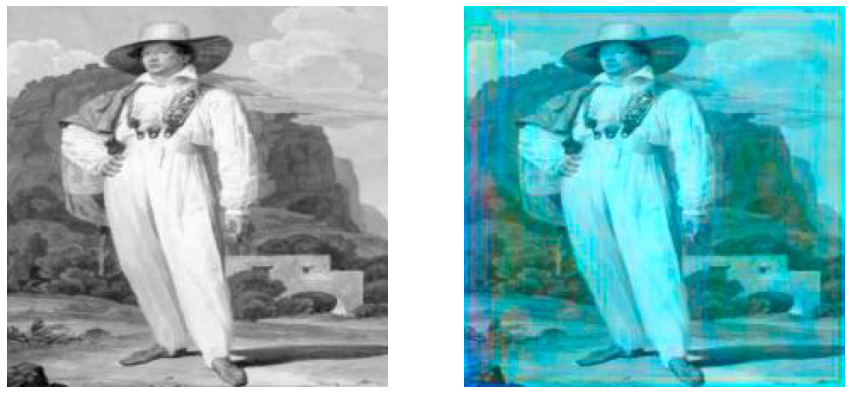

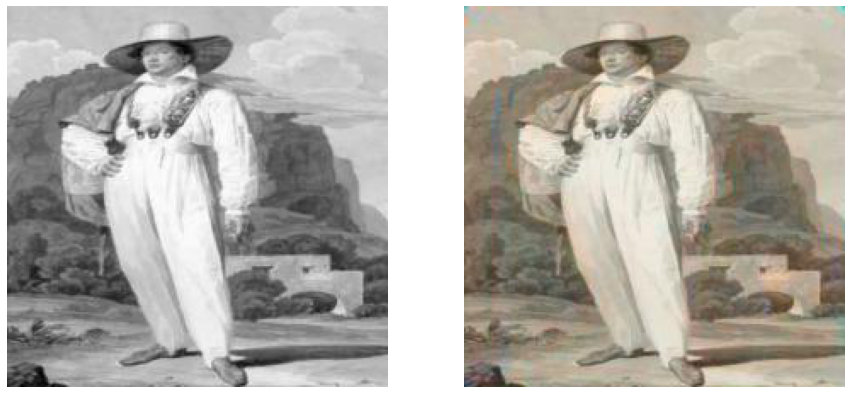

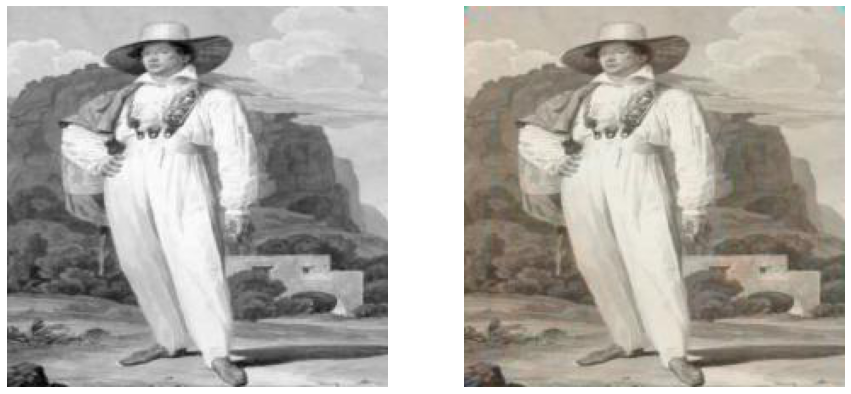

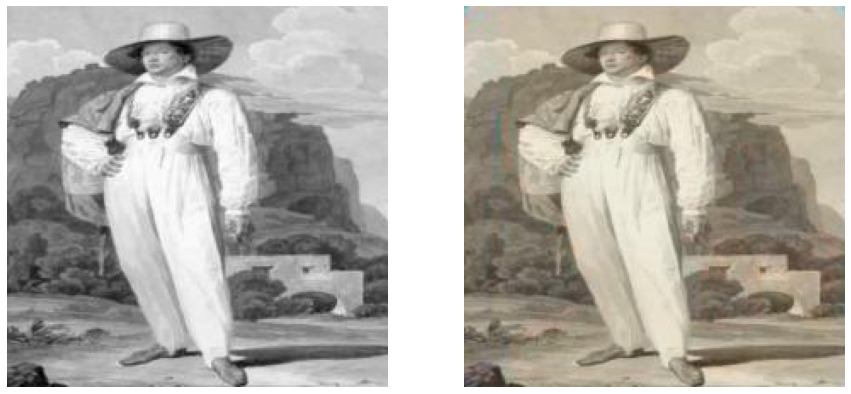

In [ ]:
# Show images 
import matplotlib.image as mpimg
image_pairs = [('outputs/color/img-0-epoch-0.jpg', 'outputs/gray/img-0-epoch-0.jpg'),
               ('outputs/color/img-0-epoch-10.jpg', 'outputs/gray/img-0-epoch-10.jpg'),
                ('outputs/color/img-0-epoch-20.jpg', 'outputs/gray/img-0-epoch-20.jpg'),
                ('outputs/color/img-0-epoch-28.jpg', 'outputs/gray/img-0-epoch-28.jpg')]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()

## Iterate throw diffirent configurations 

In [ ]:
from itertools import product

# # log samling in [1e-4 , 1e-1] for learning rate
# r = -4* np.random.rand(3)
# lr = 10 ** r
# print(lr)


parameters = dict(
    lr = [ 0.01],
    weight_decay = [0.1, 0.01]
)

param_values = [v for v in parameters.values()]

print(param_values)

for lr, weight_decay  in product(*param_values):
    print(lr, weight_decay)

[[0.01], [0.1, 0.01]]
0.01 0.1
0.01 0.01


In [ ]:
log_root = '/content/drive/MyDrive/NN_ass3/'

run id: 1
ColorizationNet,
 Optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0.0
),
 criterion: MSELoss(),
 Epochs: 50
Starting training epoch 1
Epoch: [1][1/70]	Time 0.697 (0.697)	Data 0.500 (0.500)	Loss 0.5796 (0.5796)	
Epoch: [1][21/70]	Time 0.514 (0.530)	Data 0.448 (0.453)	Loss 0.0382 (0.1306)	
Epoch: [1][41/70]	Time 0.530 (0.525)	Data 0.464 (0.453)	Loss 0.0345 (0.0821)	
Epoch: [1][61/70]	Time 0.504 (0.523)	Data 0.437 (0.452)	Loss 0.0108 (0.0611)	
Epoch: [1][70/70]	Time 0.109 (0.517)	Data 0.082 (0.447)	Loss 0.0104 (0.0557)	


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 504 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1033 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 463 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 4099 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: 

Validate: [1/8]	Time 0.725 (0.725)	Loss 0.0093 (0.0093)	
Validate: [8/8]	Time 0.260 (0.418)	Loss 0.0120 (0.0108)	
Starting training epoch 2
Epoch: [2][1/70]	Time 0.506 (0.506)	Data 0.439 (0.439)	Loss 0.0116 (0.0116)	
Epoch: [2][21/70]	Time 0.495 (0.503)	Data 0.429 (0.436)	Loss 0.0042 (0.0083)	
Epoch: [2][41/70]	Time 0.501 (0.505)	Data 0.436 (0.437)	Loss 0.0066 (0.0079)	
Epoch: [2][61/70]	Time 0.500 (0.504)	Data 0.435 (0.437)	Loss 0.0071 (0.0075)	
Epoch: [2][70/70]	Time 0.116 (0.499)	Data 0.089 (0.432)	Loss 0.0048 (0.0072)	
Validate: [1/8]	Time 0.400 (0.400)	Loss 0.0024 (0.0024)	
Validate: [8/8]	Time 0.259 (0.376)	Loss 0.0013 (0.0019)	
Starting training epoch 3
Epoch: [3][1/70]	Time 0.522 (0.522)	Data 0.456 (0.456)	Loss 0.0077 (0.0077)	
Epoch: [3][21/70]	Time 0.503 (0.507)	Data 0.437 (0.440)	Loss 0.0027 (0.0042)	
Epoch: [3][41/70]	Time 0.523 (0.508)	Data 0.454 (0.441)	Loss 0.0041 (0.0034)	
Epoch: [3][61/70]	Time 0.510 (0.508)	Data 0.444 (0.440)	Loss 0.0017 (0.0030)	
Epoch: [3][70/70]	Ti

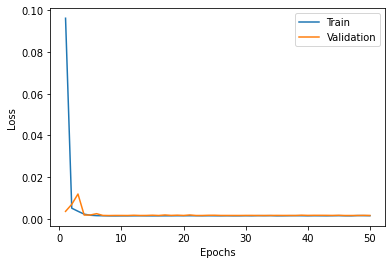

In [ ]:
epochs = 50

for run_id, (lr, weight_decay) in enumerate(product(*param_values)):
  print("run id:", run_id + 1)

  #Create Folder For Saving Results 
  os.chdir('/content') 
  log_dir = datetime.datetime.now().strftime("%m-%d %H:%M")
  os.makedirs(log_dir, exist_ok=True)
  os.chdir(log_dir)

  # Create Run Modules 
  model = ColorizationNet()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  criterion = nn.MSELoss()

  # Write Run Description to txt file 
  desc = '{},\n Optimizer {},\n criterion: {},\n Epochs: {}'.format(
                    model.__class__.__name__, optimizer , criterion,epochs)
  f= open("desc.txt","w+")
  f.write(desc)
  print(desc,'\n')

  # Move model and loss function to GPU
  if use_gpu: 
    criterion = criterion.cuda()
    model = model.cuda()

  # Make folders and set parameters
  os.makedirs('outputs/color', exist_ok=True)
  os.makedirs('outputs/gray', exist_ok=True)
  os.makedirs('checkpoints', exist_ok=True)
  
  best_losses = 1e10

  # Train model
  train_losses = []
  val_losses = []
  for epoch in range(1,epochs+1):

    # Train for one epoch, then validate
    train_loss = train(train_loader, model, criterion, optimizer, epoch)
    train_losses.append(train_loss)
    with torch.no_grad():
      save_images = False 
      if epoch % 10 == 0 or epoch == 1:
        save_images = True 
      val_loss = validate(val_loader, model, criterion, save_images, epoch)
      val_losses.append(val_loss)

    # Save checkpoint and replace old best model if current model is better
    if val_loss < best_losses:
      best_losses = val_loss
      torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch,val_loss))

  # Create DataFrame to Save Results 
  losses = pd.DataFrame({'train_loss':train_losses, 'val_Loss':val_losses})
  losses.to_pickle("losses.pkl")
  f.write('\nBest Validation Loss {:.4f}'.format(best_losses))
  f.close()

  # Plot train and validation loss
  x = np.arange(1,epochs+1)
  plt.plot(x, train_losses, label='Train')
  plt.plot(x, val_losses, label='Validation')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.savefig('loss.png')

  # Move Results to Drive
  shutil.move(os.getcwd(),log_root)

  # Seperate Frome Next Run 
  print('='*100)

os.chdir('/content') 

# Playground

In [ ]:
os.chdir('/content')

In [ ]:
shutil.rmtree('/content/05-23 17:18')

In [ ]:
print(os.listdir(os.getcwd()))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-4935844a27cb>", line 1, in <module>
    print(os.listdir(os.getcwd()))
FileNotFoundError: [Errno 2] No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'FileNotFoundError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.7/dist-pa

FileNotFoundError: ignored

In [ ]:
shutil.move(os.getcwd(),'/content/drive/MyDrive/NN_ass3/')

'/content/drive/MyDrive/NN_ass3/test_run'